## Automatic Data Cleaning, Transforming, and Annotating for EQTransformer Training

This whole process include:
- creating dataset for noise data
- creating dataset for earthquake data
- save dataset in hdf5 format

### A. Create Noise Dataset

EQTransformer identifies earthquakes while simultaneously detecting surrounding noise, making it crucial to include a balanced proportion of noise data for improved generalization.

In our training, noise data constitutes approximately 25% of the total dataset.

In [ ]:
# created dataset for noise data
import os
import h5py
import csv
import numpy as np
import glob
import pandas as pd
import time
import re
from tqdm import tqdm
from time import sleep
from datetime import datetime

import obspy
from obspy import UTCDateTime, read, Stream
from obspy.geodetics import gps2dist_azimuth
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
from pathlib import Path

# path to the file
station = Path(r"C:\Users\User\eqt-project\training\SERD_station.xlsx")
wave = Path(r"C:\Users\User\eqt-project\training\serd wave data\noise60s_serd")
csv_out = Path(r"C:\Users\User\eqt-project\training")
csv_name = r'semldataset0.csv'
hdf_name = r'semldataset0.hdf5'

# read the stations dataset
sta_df = pd.read_excel(station, index_col = None)

# create the csv file and csv writer
csv_file = open(csv_out.joinpath(f"{csv_name}"), 'w', newline='')
csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
header = ['network_code', 'receiver_code', 'receiver_type',
          'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m',
          'p_arrival_sample', 'p_status', 'p_weight', 'p_travel_sec',
          's_arrival_sample', 's_status', 's_weight',
          'source_id', 'source_origin_time', 'source_origin_uncertainty_sec',
          'source_latitude', 'source_longitude', 'source_depth_km',
          'source_distance_km', 'back_azimuth_deg',
          'source_magnitude', 'source_magnitude_type',
          'snr_db', 'coda_end_sample',
          'trace_start_time', 'trace_category', 'trace_name']
csv_writer.writerow(header)
csv_file.flush()
trace_category = 'noise'
receiver_type = 'BH'
# read wave file
wave_dir =[dir for dir in wave.iterdir()]

with tqdm(total = len(wave_dir)) as pbar:
    for wave in wave_dir:
        pbar.update()
        # get the waveform
        stream = Stream()
        for w in glob.glob(os.path.join(wave, '*.mseed'), recursive = True):
            try:
                stread = read(w)
                stream += stread
            except Exception as e:
                logger.error(f"Error reading waveform {w}: {e}") 
        sst = stream.copy()
        
        sta_list = list(sta_df.get("Stations"))
        for sta in sta_list:
            # select the traces
            try:
                traces = sst.select(station = sta)
                stats = traces[0].stats
            except Exception:
                continue
            
            # get traces metadata
            starttime = stats.starttime
            network_code = stats.network
            receiver_code = stats.station
            sta_xyz = sta_df[sta_df.Stations == receiver_code]
            sta_lat, sta_lon, sta_elev = sta_xyz.Lat.iloc[0], sta_xyz.Lon.iloc[0], sta_xyz.Elev.iloc[0]
            
            # create trace name
            trace_name = (f"{receiver_code}.{network_code}_"
                          f"{starttime.year}{starttime.month:>02}{starttime.day:>02}T{starttime.hour:>02}{starttime.minute:>02}{starttime.second:>02}_NO")
            start_date = starttime.datetime
            
            try:
                # creating dataset to be stored in hd5f file format
                data_E = traces.select(component = 'E')[0].data[:-1]
                data_N = traces.select(component = 'N')[0].data[:-1]
                data_Z = traces.select(component = 'Z')[0].data[:-1] 
                data = np.column_stack((data_E, data_N, data_Z))
                if data.shape != (6000,3):
                    continue
            except Exception as e:
                continue
            
            # write the csv contents
            csv_writer.writerow([network_code, receiver_code, receiver_type,
                                 sta_lat, sta_lon, sta_elev,
                                 '','' ,'' ,'' ,
                                 '', '','' ,
                                 '', '','' , 
                                 '', '','' ,
                                 '', '', 
                                 '', '',
                                 '', '',
                                 start_date, trace_category, trace_name])
            
            # write the hd5f file
            HDF = h5py.File(csv_out.joinpath(f'{hdf_name}'), 'a')
            dsHDF = HDF.create_dataset("data/" + trace_name, data.shape, data = data, dtype = np.float32)
            dsHDF.attrs['source_id'] = ''
            dsHDF.attrs['network_code'] = network_code
            dsHDF.attrs['receiver_code'] = receiver_code
            dsHDF.attrs['receiver_type'] = receiver_type
            dsHDF.attrs['receiver_latitude'] = sta_lat
            dsHDF.attrs['receiver_longitude'] = sta_lon
            dsHDF.attrs['receiver_elevation_m'] = sta_elev
            dsHDF.attrs['p_arrival_sample'] = ''
            dsHDF.attrs['p_status'] = ''
            dsHDF.attrs['p_weight'] = ''
            dsHDF.attrs['p_travel_sec'] = ''
            dsHDF.attrs['s_arrival_sample'] = ''
            dsHDF.attrs['s_status'] = ''
            dsHDF.attrs['s_weight'] = ''
            dsHDF.attrs['source_latitude'] = ''
            dsHDF.attrs['source_longitude'] = ''
            dsHDF.attrs['source_depth_km'] = ''
            dsHDF.attrs['source_distance_km'] = ''
            dsHDF.attrs['source_origin_time'] = ''
            dsHDF.attrs['source_origin_uncertainty_sec'] = ''
            dsHDF.attrs['back_azimuth_deg'] = ''
            dsHDF.attrs['source_magnitude'] = ''
            dsHDF.attrs['source_magnitude_type'] = ''
            dsHDF.attrs['snr_db'] = ''
            dsHDF.attrs['coda_end_sample'] = ''
            dsHDF.attrs['trace_category'] = trace_category
            dsHDF.attrs['trace_name'] = trace_name
            dsHDF.attrs['trace_start_time'] = str(start_date)
            HDF.flush()       
    HDF.close()
    csv_file.close()
    

### B. Create Earthquake Dataset (in-house Data)
Earthquake data constitutes approximately 30% of the 75% earthquake-related portion of the total dataset, which also includes noise.

In this automatic annotation process, we handle several steps to ensure that our waveform data is clean and ready for training. These steps include:

- Isolating the earthquake data from the entire 60-second segment of waveform data.
- Creating a wavelet for simple convolution, simulating the noise data while isolating the earthquake.
- Creating a phase-picking weighting scheme for each station.
- Writing the dataset and annotated waves to .csv and .hdf5 file formats.

In [ ]:
# created dataset for noise data
import os
import h5py
import csv
import numpy as np
from scipy.signal import convolve
import glob
import pandas as pd
import time
import re
from tqdm import tqdm
from time import sleep
from datetime import datetime

import obspy
from obspy import UTCDateTime, read, Stream
from obspy.geodetics import gps2dist_azimuth
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
from pathlib import Path

# create wavelet for convolution
def ricker_wavelet(f, duration, dt):
    t = np.arange(-duration/2, duration/2, dt)
    amplitude = 0.65
    a = (np.pi**2)*(f**2)*(t**2)
    wavelet = amplitude * (1 - 2 * a)*np.exp(-a)
    return t, wavelet

    
# path to the file
hypo = Path(r"C:\Users\User\eqt-project\training\hypo_reloc_seml.xlsx")
picking = Path(r"C:\Users\User\eqt-project\training\catalog_picking_seml.xlsx")
station = Path(r"C:\Users\User\eqt-project\training\SEML_station.xlsx")
wave = Path(r"C:\Users\User\eqt-project\training\wave_ai_60s")
csv_out = Path(r"C:\Users\User\eqt-project\training")

# noise_wave = Path(r"C:\Users\User\eqt-project\training\synth_noise")
csv_name = r'semldataset2.csv'
hdf_name = r'semldataset2.hdf5'

# read the data
hypo_df = pd.read_excel(hypo, index_col = None)
pick_df = pd.read_excel(picking, index_col = None)
sta_df  = pd.read_excel(station, index_col = None)

# iterate through the hypo dataframe (example)
id_start = 2719
id_end = 3659

# id list for selected events only
id_list = [3575,3604,3611,3612,3614,3615,3616,3618,3620,3636,3645,3646,3653]


# create the csv file and csv writer
csv_file = open(csv_out.joinpath(f"{csv_name}"), 'w', newline='')
csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
header = ['network_code', 'receiver_code', 'receiver_type',
          'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m',
          'p_arrival_sample', 'p_status', 'p_weight', 'p_travel_sec',
          's_arrival_sample', 's_status', 's_weight',
          'source_id', 'source_origin_time', 'source_origin_uncertainty_sec',
          'source_latitude', 'source_longitude', 'source_depth_km',
          'source_distance_km', 'back_azimuth_deg',
          'source_magnitude', 'source_magnitude_type',
          'snr_db', 'coda_end_sample',
          'trace_start_time', 'trace_category', 'trace_name']
csv_writer.writerow(header)
csv_file.flush()
trace_category = 'earthquake_local'
p_status = 'manual'
s_status = 'manual'
mag_type = 'mw'

print("""
    Creating dataset...
    Progres:
    """
    )

# Generate ricker wavelet
freq = 7
duration = 0.5
dt = 0.01
time, ricker = ricker_wavelet(freq, duration, dt)

# total selected events
sel_event = 0
with tqdm (total = (id_end - id_start) +1) as pbar:

    for _id in range(id_start, id_end +1):
#     for _id in id_list:
        pbar.update()
    
        # select the data
        hypo_dat = hypo_df[hypo_df.ID == _id]
        
        # filter the unwanted data
        try:
            if hypo_dat.Elev.iloc[0] > 1000:
                continue
            if hypo_dat.Remarks.iloc[0] == 'Initial' and hypo_dat.Mw_mag.iloc[0] < 0:
                continue
            if hypo_dat.Remarks.iloc[0] == 'Reloc' and hypo_dat.Mw_mag.iloc[0] < 0:
                continue
        except Exception:
            continue
        
        sel_event += 1
        
        # select the picking data
        pick_dat = pick_df[pick_df['Event ID'] == _id]
        
        # get the waveform
        stream = Stream()
        for w in glob.glob(os.path.join(wave.joinpath(f"{_id}"), '*.mseed'), recursive = True):
            try:
                stread = read(w)
                stream += stread
            except Exception as e:
                logger.error(f"Error reading waveform {w}: {e}") 
        sst = stream.copy()

        # get waveform parameters
        stats = stream[0].stats
        network_code = stats.network
        receiver_type = 'BH'

        # get the hypocenter parameters
        hypo_lat, hypo_lon , hypo_depth =  hypo_dat.Lat.iloc[0], hypo_dat.Lon.iloc[0], hypo_dat.Depth.iloc[0]/1000
        year = hypo_dat.Year.iloc[0]
        month = hypo_dat.Month.iloc[0]
        day = hypo_dat.Day.iloc[0]
        hour = hypo_dat.Hour.iloc[0]
        minute = hypo_dat.Minute.iloc[0]
        second_decimal = hypo_dat.T0.iloc[0]
        second = int(second_decimal)
        microsecond = int((second_decimal - second)*1e6)
        origin_time = datetime(year, month, day, hour, minute, second, microsecond)
        src_org_unc = hypo_dat.RMS_error.iloc[0]
                
        # magnitude
        mw_mag = hypo_dat.Mw_mag.iloc[0]

        for sta in pick_dat.get('Station'):
            receiver_code = sta
            sta_xyz = sta_df[sta_df.Stations == sta]
            sta_lat, sta_lon, sta_elev = sta_xyz.Lat.iloc[0], sta_xyz.Lon.iloc[0], sta_xyz.Elev.iloc[0]
            
            # Calculate the source distance and the azimuth (hypo to station azimuth)
            epicentral_distance, azimuth, back_azimuth = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon)
            source_distance = np.sqrt(epicentral_distance**2 + (hypo_depth + sta_elev)**2)
            source_distance_km = source_distance/1000
            epic_dist_km = epicentral_distance/1000
            
            # get arrival time info
            pick_info = pick_dat[pick_dat.Station == sta].iloc[0]
            p_arrival = UTCDateTime(
                f"{pick_info.Year}-{int(pick_info.Month):02d}-{int(pick_info.Day):02d}T"
                f"{int(pick_info.Hour):02d}:{int(pick_info.Minutes_P):02d}:{float(pick_info.P_Arr_Sec):012.9f}")
            s_arrival = UTCDateTime(
                f"{pick_info.Year}-{int(pick_info.Month):02d}-{int(pick_info.Day):02d}T"
                f"{int(pick_info.Hour):02d}:{int(pick_info.Minutes_S):02d}:{float(pick_info.S_Arr_Sec):012.9f}")
            
            # calculate the P travel time
            p_travel_sec = p_arrival - UTCDateTime(origin_time)
            
            # read the waveform
            try:
                traces = sst.select(station = sta)
                stat_trace = traces[0].stats
            except IndexError:
                continue
            starttime = stat_trace.starttime
            sampling_rate = stat_trace.sampling_rate

            # calculate p and s arrival as the wave sample
            p_arr_sample = int((p_arrival - starttime)*sampling_rate) 
            s_arr_sample = int((s_arrival - starttime)*sampling_rate)
            
            # determine the P and S weighting scheme
            if sta in ['ML06', 'ML09', 'ML11', 'ML14']:
                p_weight = 0.98
                s_weight = 0.95
            elif sta in ['ML02', 'ML04', 'ML05', 'ML07', 'ML12', 'ML13']:
                p_weight = 0.80
                s_weight = 0.70
            else:
                p_weight = 0.70
                s_weight = 0.65

            # create trace name
            trace_name = (f"{sta}.{network_code}_"
                          f"{starttime.year}{starttime.month:>02}{starttime.day:>02}T{starttime.hour:>02}{starttime.minute:>02}{starttime.second:>02}_EV")
            start_date = starttime.datetime
            
            try:
                # creating dataset to be stored in hd5f file format
                Tr_E = traces.select(component = 'E')[0]
                Tr_N = traces.select(component = 'N')[0]
                Tr_Z = traces.select(component = 'Z')[0]
            except Exception as e:
                continue
            
            #calculate the coda end sample
            coda_end_sample = s_arr_sample + int(( 1.7 * (s_arr_sample - p_arr_sample))) + 400 # add 4 second
            coda_end_sample_arr = np.array([[coda_end_sample]])
            
            # noise window
            noise_start_bf = 1.0 
            noise_pad = 0.3
            noise_start_sample = int((p_arrival - starttime - noise_start_bf)*sampling_rate)
            noise_end_sample  =  int((p_arrival - starttime - noise_pad)*sampling_rate)
            
            # calculate noise mean and std
            noise_E = Tr_E.data[noise_start_sample:noise_end_sample]
            noise_N = Tr_N.data[noise_start_sample:noise_end_sample]
            noise_Z = Tr_Z.data[noise_start_sample:noise_end_sample]
            E_mean, E_std = np.mean(noise_E), np.std(noise_E)
            N_mean, N_std = np.mean(noise_N), np.std(noise_N)
            Z_mean, Z_std = np.mean(noise_Z), np.std(noise_Z)

            # maniputlate the background noise and make the waveform isolated
            try:
                #seismogram = convolve(gaussian_noise, kernel, mode='same')
                Tr_E.data[:noise_end_sample] = convolve(np.random.normal(E_mean, E_std, (noise_end_sample)), ricker, mode = 'same')
                Tr_E.data[coda_end_sample:] = convolve(np.random.normal(E_mean, E_std, (6001 - coda_end_sample)), ricker, mode = 'same')
                Tr_N.data[:noise_end_sample] = convolve(np.random.normal(N_mean, N_std, (noise_end_sample)), ricker, mode = 'same')
                Tr_N.data[coda_end_sample:] = convolve(np.random.normal(N_mean, N_std, (6001 - coda_end_sample)), ricker, mode = 'same')
                Tr_Z.data[:noise_end_sample] = convolve(np.random.normal(Z_mean, Z_std, (noise_end_sample)), ricker, mode = 'same')
                Tr_Z.data[coda_end_sample:] = convolve(np.random.normal(Z_mean, Z_std, (6001 - coda_end_sample)), ricker, mode = 'same')
            except Exception:
                continue

            # do filter, detrend, and demean once again
            for tr in [Tr_E, Tr_N, Tr_Z]:
                tr.filter('bandpass', freqmin = 0.75, freqmax = 45, zerophase = True)
                tr.interpolate(sampling_rate = 100)
                tr.detrend('demean')
                tr.taper(0.1, 'cosine')
                
#             st_save = Stream(traces = [Tr_E, Tr_N, Tr_Z])
#             st_save.write(os.path.join(noise_wave, trace_name), format = 'mseed')
            
            # get synth noise data
            noise_E_synth = Tr_E.data[noise_start_sample:noise_end_sample]
            noise_N_synth = Tr_N.data[noise_start_sample:noise_end_sample]
            noise_Z_synth = Tr_Z.data[noise_start_sample:noise_end_sample]
            
            # data window
            E_data = Tr_E.data[s_arr_sample:(coda_end_sample - 60)]
            N_data = Tr_N.data[s_arr_sample:(coda_end_sample - 60)]
            Z_data = Tr_Z.data[p_arr_sample:(s_arr_sample - 40)]

            # calculate the snr
            snr_E = 10*np.log10(np.mean(E_data**2)/np.mean(noise_E_synth**2))
            snr_N = 10*np.log10(np.mean(N_data**2)/np.mean(noise_N_synth**2))
            snr_Z = 10*np.log10(np.mean(Z_data**2)/np.mean(noise_Z_synth**2))
            
            snr_db = np.array([snr_E, snr_N, snr_Z])
            # check the snr , snr must be greater than 1.5 
            if any(snr < 1.25 for snr in list(snr_db)):    
                continue
    
            # stacking the three component data
            try:
                data = np.column_stack((Tr_E.data[:-1], Tr_N.data[:-1], Tr_Z.data[:-1]))
                if data.shape != (6000,3):
                    continue
            except Exception:
                continue
            
            # write the csv contents
            csv_writer.writerow([network_code, receiver_code, receiver_type,
                                 sta_lat, sta_lon, sta_elev,
                                 p_arr_sample, p_status, p_weight, p_travel_sec,
                                 s_arr_sample, s_status, s_weight,
                                 _id, origin_time, src_org_unc, 
                                 hypo_lat, hypo_lon, hypo_depth,
                                 source_distance_km, azimuth, 
                                 mw_mag, mag_type,
                                 snr_db, coda_end_sample_arr,
                                 start_date, trace_category, trace_name])
            
            # write the hd5f file
            HDF = h5py.File(csv_out.joinpath(f'{hdf_name}'), 'a')
            dsHDF = HDF.create_dataset("data/" + trace_name, data.shape, data = data, dtype = np.float32)
            dsHDF.attrs['source_id'] = _id
            dsHDF.attrs['network_code'] = network_code
            dsHDF.attrs['receiver_code'] = receiver_code
            dsHDF.attrs['receiver_type'] = receiver_type
            dsHDF.attrs['receiver_latitude'] = sta_lat
            dsHDF.attrs['receiver_longitude'] = sta_lon
            dsHDF.attrs['receiver_elevation_m'] = sta_elev
            dsHDF.attrs['p_arrival_sample'] = p_arr_sample
            dsHDF.attrs['p_status'] = p_status
            dsHDF.attrs['p_weight'] = p_weight
            dsHDF.attrs['p_travel_sec'] = p_travel_sec
            dsHDF.attrs['s_arrival_sample'] = s_arr_sample
            dsHDF.attrs['s_status'] = s_status
            dsHDF.attrs['s_weight'] = s_weight
            dsHDF.attrs['source_latitude'] = hypo_lat
            dsHDF.attrs['source_longitude'] = hypo_lon
            dsHDF.attrs['source_depth_km'] = hypo_depth
            dsHDF.attrs['source_distance_km'] = source_distance_km
            dsHDF.attrs['source_origin_time'] = str(origin_time)
            dsHDF.attrs['source_origin_uncertainty_sec'] = src_org_unc
            dsHDF.attrs['back_azimuth_deg'] = azimuth
            dsHDF.attrs['source_magnitude'] = mw_mag
            dsHDF.attrs['source_magnitude_type'] = mag_type
            dsHDF.attrs['snr_db'] = snr_db
            dsHDF.attrs['coda_end_sample'] = coda_end_sample_arr
            dsHDF.attrs['trace_category'] = trace_category
            dsHDF.attrs['trace_name'] = trace_name
            dsHDF.attrs['trace_start_time'] = str(start_date)
            HDF.flush()       
    HDF.close()
    csv_file.close()
    
    print(f"Total selected events {sel_event}")
    

### C. Selecting Opensource Dataset (STEAD)

Due to the limited in-house data we have, we use open-source data from the Stanford Earthquake Dataset (STEAD): A Global Dataset of Seismic Signals for AI. We use a dataset of around 10K samples with the following details:

- 75% of the dataset consists of earthquakes with a magnitude below 2 on the Richter scale and a source distance not exceeding 30 km.

- 25% of the dataset consists of earthquakes with a magnitude greater than 2 and a source distance between 30 and 100 km.

In [ ]:
import h5py
from pathlib import Path
import pandas as pd
import numpy as np


# initialize path of chunks file
chunk_csv = Path(r"C:\Users\User\Downloads\Compressed\chunk2_modify.csv")
chunk_h5 = Path(r"C:\Users\User\Downloads\Compressed\chunk2.hdf5")
output = Path(r"C:\Users\User\Downloads\Compressed")

# set output of selected event
output_name = output.joinpath('chunk2_modified.hdf5')
HDF0 = h5py.File(output_name, 'a')
HDF0.create_group("data")

# read dataframe
chunk_pd = pd.read_csv(chunk_csv)

# read the h5 file
chunk_hdf = h5py.File(chunk_h5, 'r')

# iterate trough the dataframe
for ev in chunk_pd.get("trace_name"):
    x = chunk_hdf.get("data/" + str(ev))
    data = np.array(x)
    
    # set appendable HDF file
    HDFr = h5py.File(output_name, 'a')
    dsF = HDFr.create_dataset("data/"+ev, data.shape, data=data, dtype=np.float32)
    dsF.attrs['source_id'] = x.attrs['source_id']
    dsF.attrs['network_code'] = x.attrs['network_code']
    dsF.attrs['receiver_code'] = x.attrs['receiver_code']
    dsF.attrs['receiver_type'] = x.attrs['receiver_type']
    dsF.attrs['receiver_latitude'] = x.attrs['receiver_latitude']
    dsF.attrs['receiver_longitude'] = x.attrs['receiver_longitude']
    dsF.attrs['receiver_elevation_m'] = x.attrs['receiver_elevation_m']
    dsF.attrs['p_arrival_sample'] = x.attrs['p_arrival_sample']
    dsF.attrs['p_status'] = x.attrs['p_status']
    dsF.attrs['p_weight'] = x.attrs['p_weight']
    dsF.attrs['p_travel_sec'] = x.attrs['p_travel_sec']
    dsF.attrs['s_arrival_sample'] = x.attrs['s_arrival_sample']
    dsF.attrs['s_status'] = x.attrs['s_status']
    dsF.attrs['s_weight'] = x.attrs['s_weight']
    dsF.attrs['source_latitude'] = x.attrs['source_latitude']
    dsF.attrs['source_longitude'] = x.attrs['source_longitude']
    dsF.attrs['source_depth_km'] = x.attrs['source_depth_km']
    dsF.attrs['source_distance_km'] = x.attrs['source_distance_km']
    dsF.attrs['source_origin_time'] = x.attrs['source_origin_time']
    dsF.attrs['source_origin_uncertainty_sec'] = x.attrs['source_origin_uncertainty_sec']
    dsF.attrs['back_azimuth_deg'] = x.attrs['back_azimuth_deg']
    dsF.attrs['source_magnitude'] = x.attrs['source_magnitude']
    dsF.attrs['source_magnitude_type'] = x.attrs['source_magnitude_type']
    dsF.attrs['snr_db'] = x.attrs['snr_db']
    dsF.attrs['coda_end_sample'] = x.attrs['coda_end_sample']
    dsF.attrs['trace_category'] = x.attrs['trace_category'] 
    dsF.attrs['trace_name'] = x.attrs['trace_name'] 
    dsF.attrs['trace_start_time'] = x.attrs['trace_start_time']
    HDFr.flush() 
HDFr.close()

 

### D. Merging Function to Combine all Datasets

In [ ]:
import h5py
import csv
import numpy as np
import glob

 
def main(inp_name): 
    '''
        This function gets a string (name of output files) as input, generates two files:
        "input_name.hdf5" and "input_name.csv" and write the contents of all chunk?.hdf5 
        files in the same directory into them. 
    '''
    output_merge = inp_name+'.hdf5'
    HDF0 = h5py.File(output_merge, 'a')
    HDF0.create_group("data")
     
    csvfile = open(output_merge.split('.')[0]+'.csv', 'w', newline='')          
    output_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    output_writer.writerow(['network_code', 'receiver_code', 'receiver_type',
          'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m',
          'p_arrival_sample', 'p_status', 'p_weight', 'p_travel_sec',
          's_arrival_sample', 's_status', 's_weight',
          'source_id', 'source_origin_time', 'source_origin_uncertainty_sec',
          'source_latitude', 'source_longitude', 'source_depth_km',
          'source_distance_km', 'back_azimuth_deg',
          'source_magnitude', 'source_magnitude_type',
          'snr_db', 'coda_end_sample',
          'trace_start_time', 'trace_category', 'trace_name'])
    csvfile.flush()
    print('output files have been generated!')
    
    for h5name in glob.glob('semldataset*.hdf5'):
        print('working on '+h5name+'...')
        dtfl = h5py.File(h5name, 'r') 
        for evi in dtfl['data']:
            print(evi)
            x = dtfl.get('data/'+str(evi)) 
            data = np.array(x)
                   
            HDFr = h5py.File(output_merge, 'a')
            dsF = HDFr.create_dataset("data/"+evi, data.shape, data=data, dtype=np.float32) 
            
            dsF.attrs['source_id'] = x.attrs['source_id']
            dsF.attrs['network_code'] = x.attrs['network_code']
            dsF.attrs['receiver_code'] = x.attrs['receiver_code']
            dsF.attrs['receiver_type'] = x.attrs['receiver_type']
            dsF.attrs['receiver_latitude'] = x.attrs['receiver_latitude']
            dsF.attrs['receiver_longitude'] = x.attrs['receiver_longitude']
            dsF.attrs['receiver_elevation_m'] = x.attrs['receiver_elevation_m']
            dsF.attrs['p_arrival_sample'] = x.attrs['p_arrival_sample']
            dsF.attrs['p_status'] = x.attrs['p_status']
            dsF.attrs['p_weight'] = x.attrs['p_weight']
            dsF.attrs['p_travel_sec'] = x.attrs['p_travel_sec']
            dsF.attrs['s_arrival_sample'] = x.attrs['s_arrival_sample']
            dsF.attrs['s_status'] = x.attrs['s_status']
            dsF.attrs['s_weight'] = x.attrs['s_weight']
            dsF.attrs['source_latitude'] = x.attrs['source_latitude']
            dsF.attrs['source_longitude'] = x.attrs['source_longitude']
            dsF.attrs['source_depth_km'] = x.attrs['source_depth_km']
            dsF.attrs['source_distance_km'] = x.attrs['source_distance_km']
            dsF.attrs['source_origin_time'] = x.attrs['source_origin_time']
            dsF.attrs['source_origin_uncertainty_sec'] = x.attrs['source_origin_uncertainty_sec']
            dsF.attrs['back_azimuth_deg'] = x.attrs['back_azimuth_deg']
            dsF.attrs['source_magnitude'] = x.attrs['source_magnitude']
            dsF.attrs['source_magnitude_type'] = x.attrs['source_magnitude_type']
            dsF.attrs['snr_db'] = x.attrs['snr_db']
            dsF.attrs['coda_end_sample'] = x.attrs['coda_end_sample']
            dsF.attrs['trace_category'] = x.attrs['trace_category'] 
            dsF.attrs['trace_name'] = x.attrs['trace_name'] 
            dsF.attrs['trace_start_time'] = x.attrs['trace_start_time']
            HDFr.flush() 
           
             
            output_writer.writerow([
                                    x.attrs['network_code'], 
                                    x.attrs['receiver_code'], 
                                    x.attrs['receiver_type'],
                                    x.attrs['receiver_latitude'], 
                                    x.attrs['receiver_longitude'], 
                                    x.attrs['receiver_elevation_m'], 
                                    x.attrs['p_arrival_sample'], 
                                    x.attrs['p_status'],
                                    x.attrs['p_weight'], 
                                    x.attrs['p_travel_sec'], 
                                    x.attrs['s_arrival_sample'],
                                    x.attrs['s_status'], 
                                    x.attrs['s_weight'],
                                    x.attrs['source_id'], 
                                    x.attrs['source_origin_time'], 
                                    x.attrs['source_origin_uncertainty_sec'], 
                                    x.attrs['source_latitude'],
                                    x.attrs['source_longitude'],
                                    x.attrs['source_depth_km'],
                                    x.attrs['source_distance_km'],
                                    x.attrs['back_azimuth_deg'],
                                    x.attrs['source_magnitude'], 
                                    x.attrs['source_magnitude_type'], 
                                    x.attrs['snr_db'],
                                    x.attrs['coda_end_sample'],
                                    x.attrs['trace_start_time'], 
                                    x.attrs['trace_category'], 
                                    x.attrs['trace_name']]); 
            csvfile.flush()        
            HDFr.close()    
                
        
if __name__ == '__main__':
  #  inp_name=input("Please enter a name for the output files!") 
    inp_name="merged"    
    main(inp_name)    

## Accessing Annotate Earthquake Data

In [10]:
import h5py
# load the data
hdr = r"C:\Users\User\eqt-project\training\chunks2\merged.hdf5"
#hdr = r"semldataset.hdf5"
data = h5py.File(hdr, 'r')
trace = data['data']['ML06.ML_20230120T132906_EV']
for attr in trace.attrs:
    print(f"{attr}:{trace.attrs[attr]}")

back_azimuth_deg:303.8332240655873
coda_end_sample:[[1143]]
network_code:ML
p_arrival_sample:592
p_status:manual
p_travel_sec:0.750163
p_weight:0.98
receiver_code:ML06
receiver_elevation_m:1396
receiver_latitude:-1.635350219
receiver_longitude:101.1419969
receiver_type:BH
s_arrival_sample:648
s_status:manual
s_weight:0.95
snr_db:[15.30048343 14.94952752 10.84766483]
source_depth_km:1.09742
source_distance_km:1.933008310677263
source_id:2737
source_latitude:-1.6420769
source_longitude:101.1519694
source_magnitude:-0.281030272193492
source_magnitude_type:mw
source_origin_time:2023-01-20 13:29:11.170000
source_origin_uncertainty_sec:0.0130297
trace_category:earthquake_local
trace_name:ML06.ML_20230120T132906_EV
trace_start_time:2023-01-20 13:29:06


(6000, 3)


C:\Users\User\anaconda3\envs\eqt-project\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


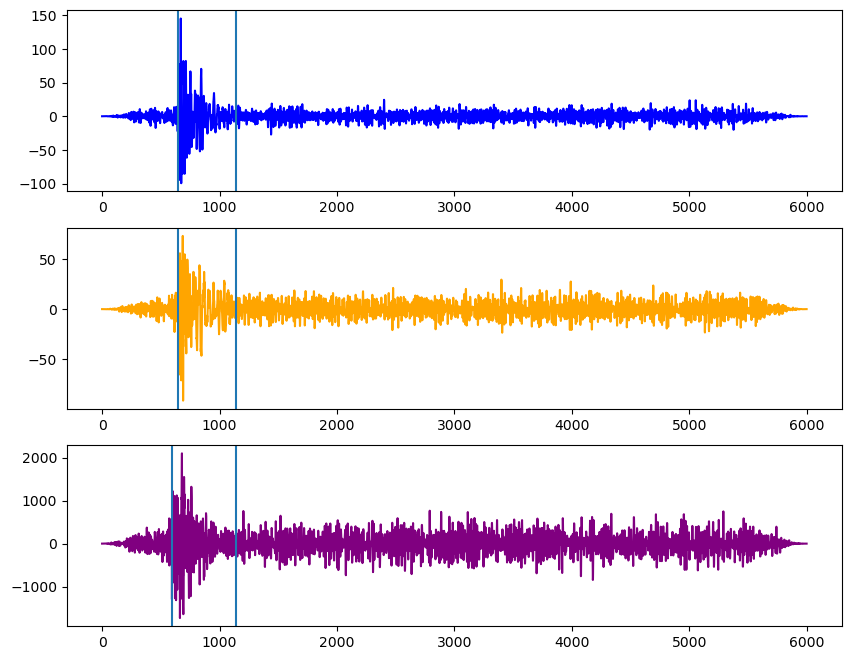

In [12]:
import matplotlib.pyplot as plt
print(trace.shape)
p_arr = trace.attrs['p_arrival_sample']
s_arr = trace.attrs['s_arrival_sample']
coda = trace.attrs['coda_end_sample']
tr_E = [i[0] for i in trace]
tr_N = [i[1] for i in trace]
tr_Z = [i[2] for i in trace]
fig, axs = plt.subplots(3,figsize =(10,8))
axs[0].plot(tr_E, color='blue')
axs[1].plot(tr_N, color='orange')
axs[2].plot(tr_Z, color='purple')
axs[0].axvline(s_arr)
axs[1].axvline(s_arr)
axs[2].axvline(p_arr)
axs[0].axvline(coda)
axs[1].axvline(coda)
axs[2].axvline(coda)
fig.show()

## Accessing Annotated Noise Data

back_azimuth_deg:
coda_end_sample:
network_code:RD
p_arrival_sample:
p_status:
p_travel_sec:
p_weight:
receiver_code:RD10
receiver_elevation_m:2412
receiver_latitude:-4.231261
receiver_longitude:103.359078
receiver_type:BH
s_arrival_sample:
s_status:
s_weight:
snr_db:
source_depth_km:
source_distance_km:
source_id:
source_latitude:
source_longitude:
source_magnitude:
source_magnitude_type:
source_origin_time:
source_origin_uncertainty_sec:
trace_category:noise
trace_name:RD10.RD_20240701T112800_NO
trace_start_time:2024-07-01 11:28:00


C:\Users\User\anaconda3\envs\eqt-project\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


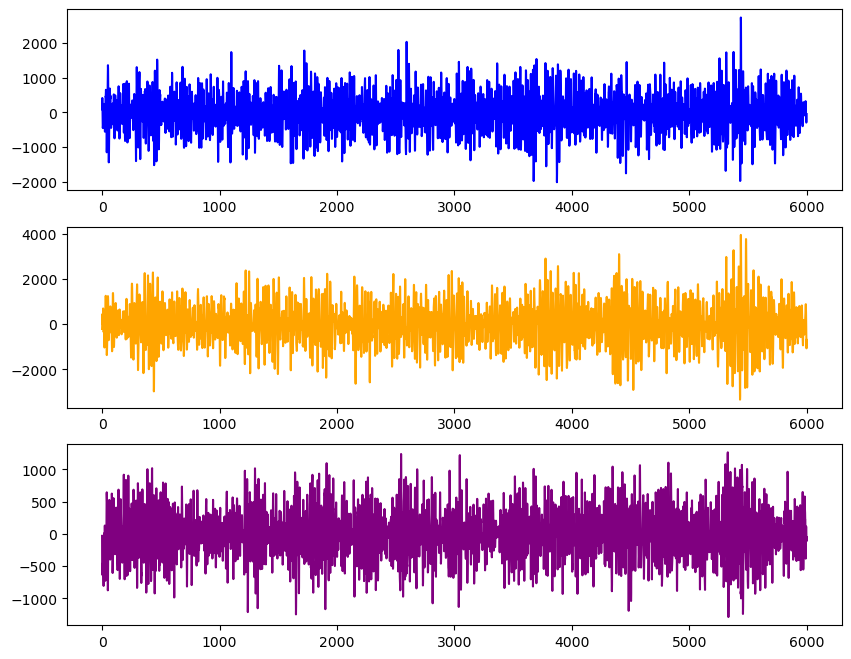

In [16]:
import h5py
import matplotlib.pyplot as plt

# load the data
hdr = r"C:\Users\User\eqt-project\training\chunks2\merged.hdf5"
#hdr = r"semldataset.hdf5"
data = h5py.File(hdr, 'r')

trace = data['data']['RD10.RD_20240701T112800_NO']
for attr in trace.attrs:
    print(f"{attr}:{trace.attrs[attr]}")

tr_E = [i[0] for i in trace]
tr_N = [i[1] for i in trace]
tr_Z = [i[2] for i in trace]
fig, axs = plt.subplots(3,figsize =(10,8))
axs[0].plot(tr_E, color='blue')
axs[1].plot(tr_N, color='orange')
axs[2].plot(tr_Z, color='purple')
fig.show()